## Exercício 3

In [223]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

iris = fetch_ucirepo(id=53) 

pd.set_option("display.max_rows", None)

X = iris.data.features.copy()   # features (pandas DataFrame)
y = iris.data.targets.copy()    # targets (pandas DataFrame)

### 1)

In [224]:
features = {"sepal length", "sepal width", "petal length", "petal width"}

for feature in features:
    q1, q2 = X[feature].quantile([1/3, 2/3])
    X[feature] = pd.cut(X[feature],
                            bins=[-np.inf, q1, q2, np.inf],
                            labels=['low','medium','high'])

print(X.to_markdown())

|     | sepal length   | sepal width   | petal length   | petal width   |
|----:|:---------------|:--------------|:---------------|:--------------|
|   0 | low            | high          | low            | low           |
|   1 | low            | medium        | low            | low           |
|   2 | low            | medium        | low            | low           |
|   3 | low            | medium        | low            | low           |
|   4 | low            | high          | low            | low           |
|   5 | low            | high          | low            | low           |
|   6 | low            | high          | low            | low           |
|   7 | low            | high          | low            | low           |
|   8 | low            | low           | low            | low           |
|   9 | low            | medium        | low            | low           |
|  10 | low            | high          | low            | low           |
|  11 | low            | high         

In [225]:
def stratified_split_indices(y, test_size=0.3, random_state=None):
    rng = np.random.default_rng(random_state)
    train_idx = []
    test_idx = []
    for cls in np.unique(y):
        idx = np.where(y == cls)[0].copy()
        rng.shuffle(idx)
        n_test = int(np.round(len(idx) * test_size))
        test_idx.extend(idx[:n_test])
        train_idx.extend(idx[n_test:])
    return np.array(train_idx, dtype=int), np.array(test_idx, dtype=int)

def NaiveBayesClassifier(X_tr, y_tr, X_te):
    classes = {"Iris-setosa", "Iris-versicolor", "Iris-virginica"}

    # Calculate class probabilities - P(y)
    class_probs = y_tr.value_counts(normalize=True)
    class_probs.index = classes
    class_probs = class_probs.to_dict()

    feature_probs = {}

    for cls in classes:
        # Calculate feature probabilities - P(x|y)
        # ex: "y = Iris-setosa"
        class_data = X_tr[y_tr["class"] == cls]
        feature_probs[cls] = {}

        for feature in features:     # ex: "x = sepal length"
            feature_probs[cls][feature] = class_data.value_counts(feature, normalize=True).to_dict()


    predictions = []
    
    for _,row in X_te.iterrows():
        class_scores = {}
        
        for cls in classes:
            score = class_probs[cls]    #P(y)
            
            # Multiply probabilities of features - P(y)*P(x1|y)*P(x2|y)...
            for feature in features:
                value = row[feature]
                score *= feature_probs[cls][feature][value]
            
            class_scores[cls] = score
        
        # Predict class with highest score
        predicted_class = max(class_scores, key=class_scores.get)
        predictions.append(predicted_class)
        
    return predictions

def build_confusion_matrix(y_true, y_pred):

    labels = {"Iris-setosa": 0, "Iris-versicolor": 1, "Iris-virginica": 2}

    cm = np.zeros((3, 3), dtype=int)
    
    for true_lbl, pred_lbl in zip(y_true, y_pred):
        i = labels[true_lbl]
        j = labels[pred_lbl]
        cm[i, j] += 1
    
    return cm

def plot_confusion_matrix(cm):

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.colorbar()
    plt.xticks(np.arange(3), ["Iris-setosa", "Iris-versicolor", "Iris-virginica"])
    plt.yticks(np.arange(3), ["Iris-setosa", "Iris-versicolor", "Iris-virginica"])
    plt.title("Confusion Matrix, without normalization")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    for i in range(3):
        for j in range(3):
            color = "white" if cm[i, j] > cm.max() / 2 else "black"
            plt.text(j, i, cm[i, j], ha="center", va="center", color=color)
    
    plt.tight_layout()
    plt.show()

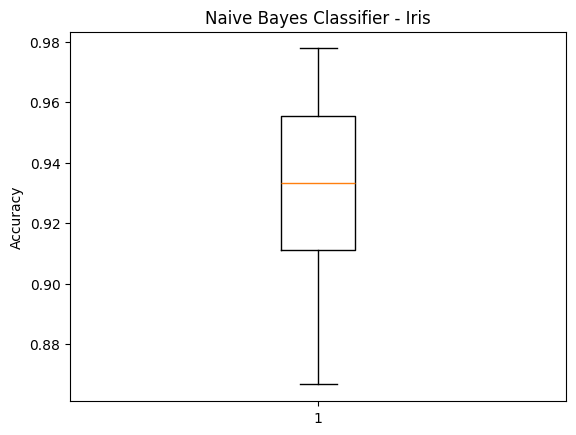

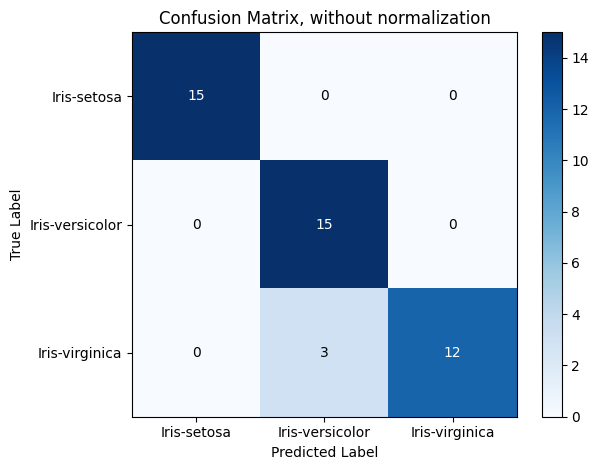

In [230]:
cm = None
accuracy = []

for i in range(30):
    train_idx, test_idx = stratified_split_indices(y, 0.30)
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx].iloc[:, 0].to_list()
    
    y_pred = NaiveBayesClassifier(X_tr, y_tr, X_te)
    accuracy.append(np.mean(np.array(y_te) == np.array(y_pred)))

    if i == 29:
        cm = build_confusion_matrix(y_te, y_pred)

plt.figure()
plt.boxplot(accuracy)
plt.ylabel('Accuracy')
plt.title('Naive Bayes Classifier - Iris')
plt.show()

#print(np.array(accuracy))

plot_confusion_matrix(cm)